#  Автоэнкодеры. GAN.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* https://www.eecs.qmul.ac.uk/~sgg/_ECS795P_/papers/WK07-8_PyTorch_Tutorial2.html
* https://www.youtube.com/watch?v=zp8clK9yCro
* https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
* https://towardsdatascience.com/conditional-variational-autoencoders-with-learnable-conditional-embeddings-e22ee5359a2a
* https://pytorch.org/vision/stable/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://www.kaggle.com/datasets/splcher/animefacedataset
* https://github.com/eriklindernoren/PyTorch-GAN

## Задачи для совместного разбора

1\. Обсудите основные шаги в обучении автокодировщиков.

## Задачи для самостоятельного решения

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim import Adam
import torchvision
import torchvision.transforms.v2 as T
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score
from pytorch_lightning.loggers import MLFlowLogger
import numpy as np
from typing import Tuple, List, Optional
import matplotlib.pyplot as plt
import os
import zipfile
import requests
from io import BytesIO
import mlflow
import subprocess
from PIL import Image
from IPython.display import Image as dispImage
import sys

<p class="task" id="1"></p>

1\. Загрузите набор данных MNIST из пакета `torchvision` (данный набор уже разбит на обучающее и тестовое множество). 

Создайте и обучите модель автокодировщика, используя только полносвязные слои и функции активации. 

Кодировщик - это функция вида 
$z = f_\theta(x)$
,где $\theta$ - это параметры кодировщика.

Декодировщик - это функция вида 
$\hat{x} = g_\phi(z)$
,где $\phi$ - это параметры декодировщика.

В нашем случае оба компонента представляют собой нейронные сети. Скрытое представление, полученное после части-кодировщика, должно иметь размерность 2. Последним слоем части-декодеровщика сделайте сигмоиду. 

В качестве функции потерь используйте `MSELoss` между исходным и восстановленным изображением $MSE(x, \hat{x})$. 

Обратите внимание, что во время обучения метки классов не используются.


- [ ] Проверено на семинаре

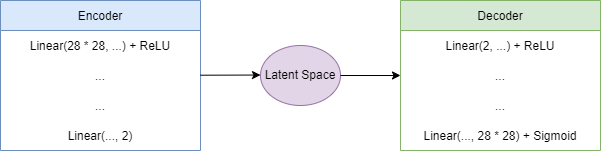

In [21]:
INPUT_DIM = 28 * 28
LATENT_DIM = 2      
HIDDEN_DIM_1 = 128
HIDDEN_DIM_2 = 64
NUM_CLASSES = 10
BATCH_SIZE = 256
MAX_EPOCHS = 40
LR = 1e-3
DATA_DIR = './data_mnist'

In [8]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = DATA_DIR, batch_size: int = BATCH_SIZE):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        
        self.transform = T.Compose([
            T.ToTensor(),
        ])

    def prepare_data(self):
        torchvision.datasets.MNIST(self.data_dir, train=True, download=True)
        torchvision.datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: Optional[str] = None):
        self.train_ds = torchvision.datasets.MNIST(
            self.data_dir, train=True, transform=self.transform
        )
        self.test_ds = torchvision.datasets.MNIST(
            self.data_dir, train=False, transform=self.transform
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds, 
            batch_size=self.batch_size, 
            shuffle=True, 
            num_workers=4
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=4
        )
        


In [9]:
class Autoencoder(pl.LightningModule):
    def __init__(self, input_dim: int, latent_dim: int, h1: int, h2: int, lr: float):
        super().__init__()
        self.save_hyperparameters() 
        
        # 784 -> 128 -> 64 -> 2 (Latent Dim)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, latent_dim)
        )
        
        # 2 -> 64 -> 128 -> 784 (с Sigmoid)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, h2),
            nn.ReLU(),
            nn.Linear(h2, h1),
            nn.ReLU(),
            nn.Linear(h1, input_dim),
            nn.Sigmoid()
        )
        
        self.loss_fn = nn.MSELoss()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = x.view(x.size(0), -1) 
        z = self.encoder(x) # [B, 2]
        x_hat = self.decoder(z) # [B, 784]
        
        return x_hat, z

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        x, _ = batch 
        
        x_hat, _ = self(x)
        
        x_flat = x.view(x.size(0), -1)
        loss = self.loss_fn(x_hat, x_flat)
        
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        x, _ = batch
        x_hat, _ = self(x)
        x_flat = x.view(x.size(0), -1)
        loss = self.loss_fn(x_hat, x_flat)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.hparams.lr)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x.view(x.size(0), -1))

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)
    


In [22]:
data_module = MNISTDataModule()
model = Autoencoder(INPUT_DIM, LATENT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, LR)

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="auto", 
    devices=1,
    log_every_n_steps=50,
)

trainer.fit(model, data_module)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 108 K  | train
1 | decoder | Sequential | 109 K  | train
2 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.874     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


<p class="task" id="2"></p>

2\. Получите один батч из тестового множества. Используя модель, обученную в предыдущем задании, получите скрытые представления для всех изображений из этого батча и визуализируйте на плоскости (они должны иметь размерность 2!). Раскрасьте точки в цвета, соответствующие меткам класса изображений (цифрам).

Возьмите одно изображение из тестового множества и пропустите его через обученный автокодировщик. Визуализируйте рядом (по горизонтали) два изображения: исходное и после восстановления автокодировщиком.


- [ ] Проверено на семинаре

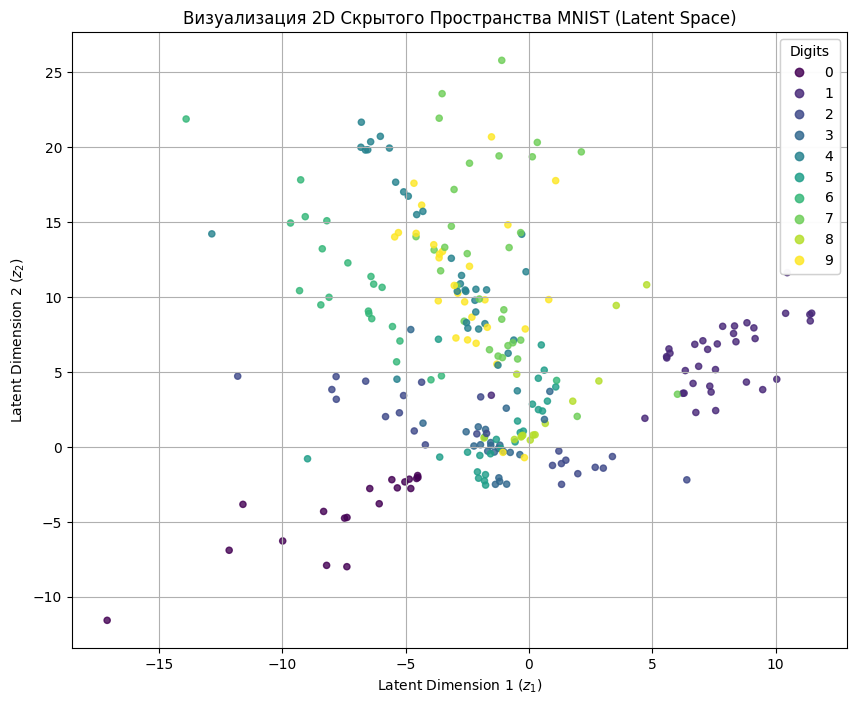

In [ ]:
test_dataloader = data_module.test_dataloader()
x_test, y_test = next(iter(test_dataloader))
x_test = x_test.to(model.device) 
y_test_np = y_test.cpu().numpy() 

model.eval() 
with torch.no_grad():
    z = model.encode(x_test) # [Batch_Size, 2]
    z_np = z.cpu().numpy()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    z_np[:, 0], 
    z_np[:, 1], 
    c=y_test_np,           
    cmap='viridis',       
    alpha=0.8,
    s=20                  
)

legend1 = plt.legend(*scatter.legend_elements(), 
                     loc="upper right", 
                     title="Digits")
plt.gca().add_artist(legend1)

plt.xlabel("Latent Dimension 1 ($z_1$)")
plt.ylabel("Latent Dimension 2 ($z_2$)")
plt.title("Визуализация 2D Скрытого Пространства MNIST (Latent Space)")
plt.grid(True)
plt.show()

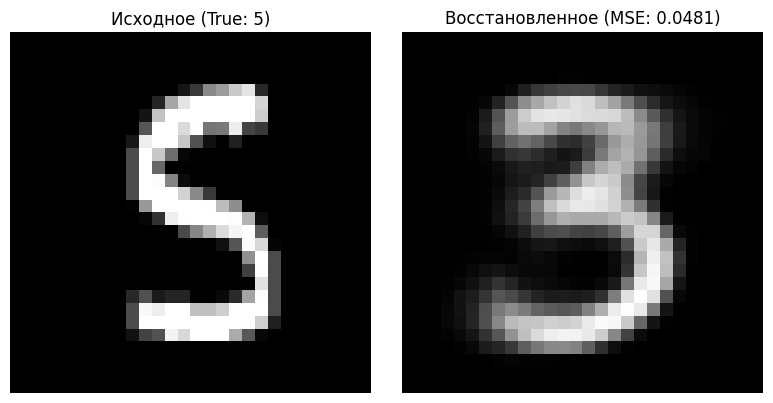

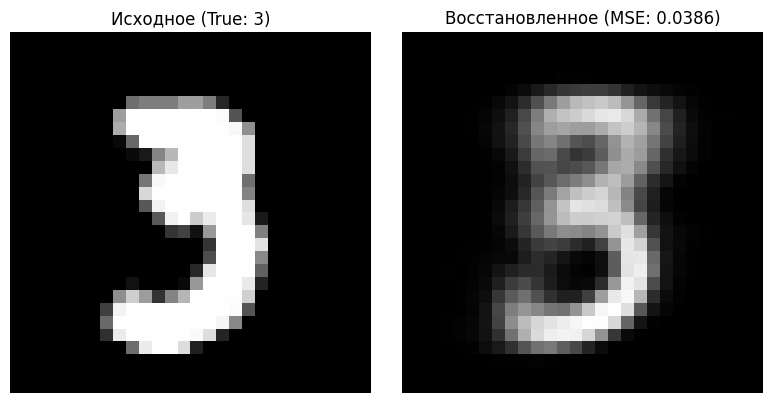

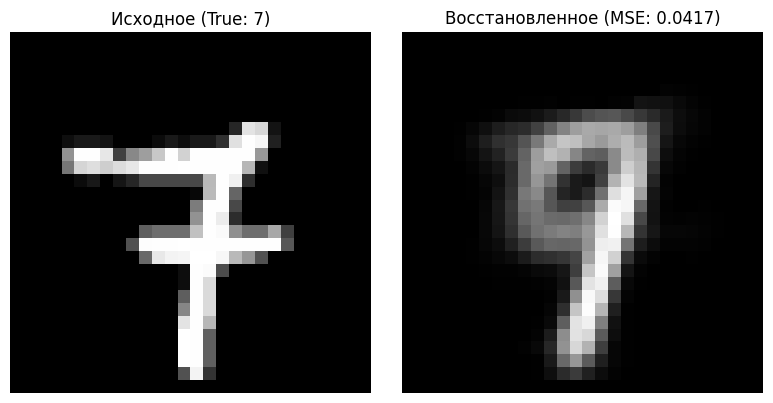

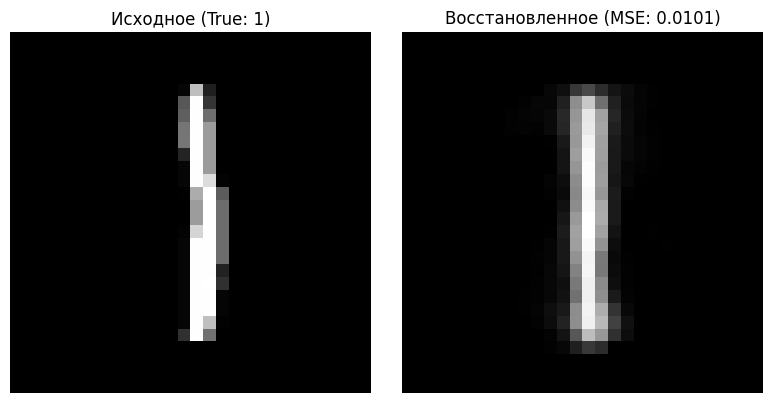

In [24]:
sample_indexes = np.random.choice(len(x_test), (4,))
for sample_index in sample_indexes:
    x_original = x_test[sample_index].cpu() # [1, 28, 28]
    y_true = y_test[sample_index].item()

    x_input_for_model = x_test[sample_index].unsqueeze(0) # [1, 1, 28, 28]

    with torch.no_grad():
        x_hat_flat, z_single = model(x_input_for_model) # x_hat_flat: [1, 784]

    #  [1, 28, 28] -> [28, 28]
    x_original_img = x_original.squeeze().numpy()

    # [1, 784] -> [28, 28]
    x_hat_img = x_hat_flat.squeeze().cpu().numpy().reshape(28, 28)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(x_original_img, cmap='gray')
    axes[0].set_title(f"Исходное (True: {y_true})")
    axes[0].axis('off')

    axes[1].imshow(x_hat_img, cmap='gray')
    mse_val = F.mse_loss(x_hat_flat, x_original.view(1, -1).to(model.device)).item()

    axes[1].set_title(f"Восстановленное (MSE: {mse_val:.4f})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

Вряд ли с этого можно обучить что-то стоящее

<p class="task" id="3"></p>

3\. Напишите функцию для генерации изображения на основе случайного шума. Функция должна генерировать случайный шум из стандартного нормального распределения и пропускать его через часть-декодировщик. Сгенерируйте несколько изображений и визуализируйте в виде сетки из картинок.

- [ ] Проверено на семинаре

In [ ]:
def generate_images_from_noise(model: Autoencoder, num_samples: int = 16, latent_dim: int = LATENT_DIM):
    model.eval()
    device = next(model.parameters()).device

    noise = torch.randn(num_samples, latent_dim).to(device) # [num_samples, 2]

    with torch.no_grad():
        # x_hat_flat: [num_samples, 784]
        x_hat_flat = model.decode(noise) 
    
    # [num_samples, 784] -> [num_samples, 28, 28]
    images_np = x_hat_flat.cpu().numpy().reshape(num_samples, 28, 28)
    
    return images_np

def visualize_grid(images_np: np.ndarray, title: str, grid_size: Tuple[int, int]):
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < len(images_np):
            ax.imshow(images_np[i], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

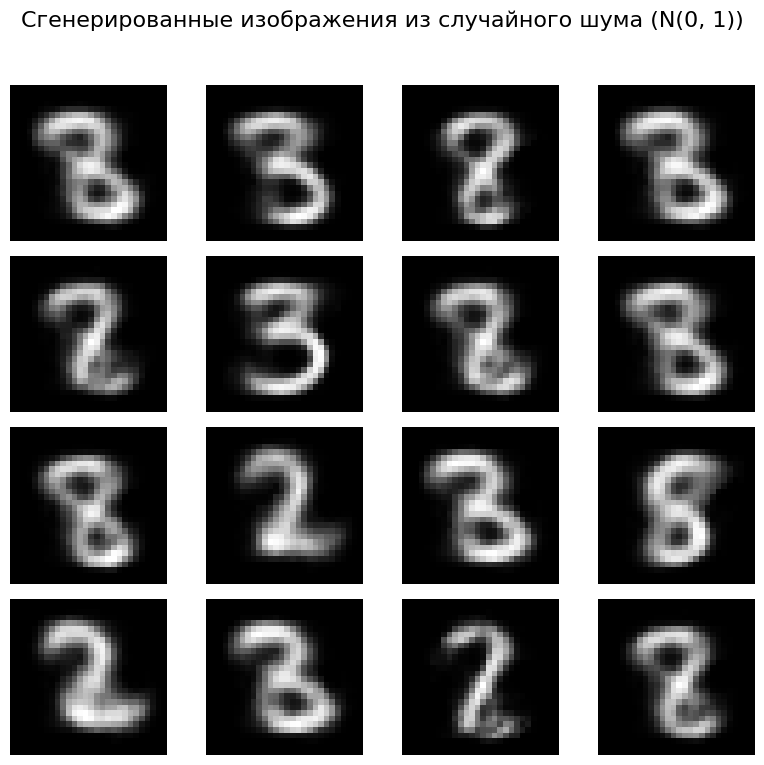

In [ ]:
GRID_SIZE = (4, 4)
NUM_SAMPLES = GRID_SIZE[0] * GRID_SIZE[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

generated_images = generate_images_from_noise(model, NUM_SAMPLES)
visualize_grid(
    generated_images, 
    "Сгенерированные изображения из случайного шума (N(0, 1))", 
    GRID_SIZE
)

<p class="task" id="4"></p>

4\. Создайте набор данных на основе датасета `animefacedataset`. Используя преобразования `torchvision`, приведите изображения к одному размеру и нормализуйте их. Выведите на экран несколько примеров изображений. 

- [ ] Проверено на семинаре

In [34]:
IMAGE_SIZE = 64 
DATA_ROOT = './data_anime'
EXTRACTED_FOLDER = os.path.join(DATA_ROOT, 'animefacedataset')
ANIME_IMAGE_DIR = os.path.join(EXTRACTED_FOLDER, 'images')

In [56]:
gan_transforms = T.Compose([
    T.Resize(IMAGE_SIZE), 
    T.CenterCrop(IMAGE_SIZE),   
    T.ToTensor(),               
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

anime_dataset = torchvision.datasets.ImageFolder(
    root=EXTRACTED_FOLDER,
    transform=gan_transforms
)

BATCH_SIZE_GAN = 128 
anime_dataloader = torch.utils.data.DataLoader(
    anime_dataset,
    batch_size=BATCH_SIZE_GAN,
    shuffle=True,
    num_workers=10,
    pin_memory=True,
    persistent_workers=True
)

print(f"Загружено {len(anime_dataset)} изображений. Размер батча: {BATCH_SIZE_GAN}.")

Загружено 63565 изображений. Размер батча: 128.


In [37]:
def denormalize_image_gan(tensor: torch.Tensor) -> np.ndarray:
    img_np = tensor.cpu().numpy()
    img_np = (img_np * 0.5) + 0.5
    img_np = np.clip(img_np, 0, 1).transpose(1, 2, 0)
    
    return img_np

def visualize_anime_batch(dataloader, num_images: int = 16):
    data_iter = iter(dataloader)
    images, _ = next(data_iter)
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(f"Примеры изображений Anime (Размер: {IMAGE_SIZE}x{IMAGE_SIZE})", fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img_tensor = images[i]
            img_np = denormalize_image_gan(img_tensor)
            ax.imshow(img_np)
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

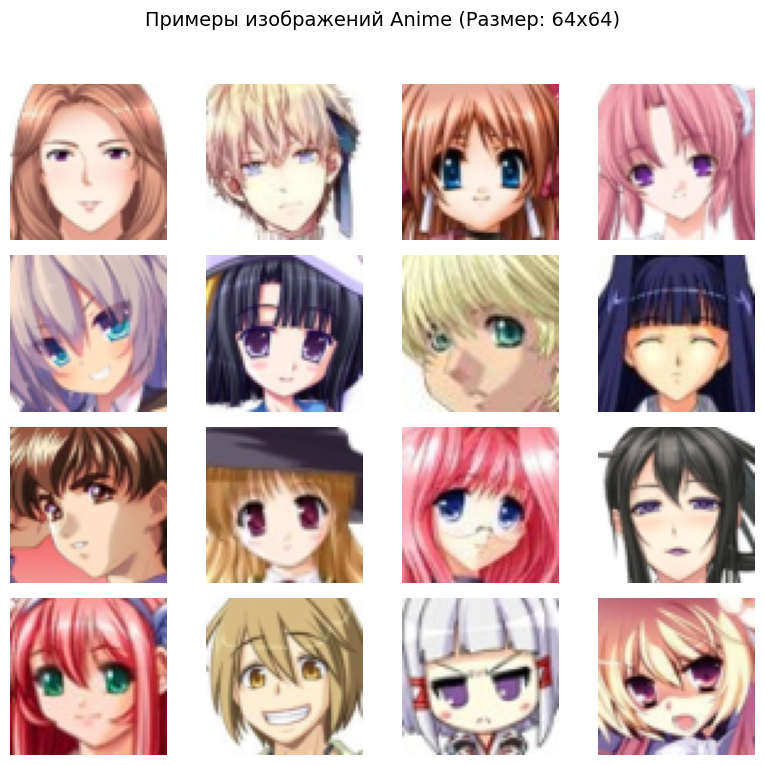

In [38]:
visualize_anime_batch(anime_dataloader, num_images=16)

<p class="task" id="5"></p>

5\. Реализуйте архитектуру `DCGAN` и обучите модель. Подберите гиперпараметры таким образом, чтобы получаемые изображения стали достаточного качественными (четкими и без существенных дефектов). Во время обучения сохраняйте примеры генерации изображений из случайного шума и сравните, как менялось качество получаемых изображений в процессе обучения.

- [ ] Проверено на семинаре

In [39]:
Z_DIM = 100
FEAT_G = 64
FEAT_D = 64
LR_GAN = 0.0002
BETAS = (0.5, 0.999)
NUM_CHANNELS = 3

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [40]:
class Generator(nn.Module):
    def __init__(self, z_dim: int, nc: int, ngf: int):
        super().__init__()
        self.main = nn.Sequential(
            # Вход: z (Noise)  [B, z_dim, 1, 1]
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # [B, ngf*8, 4, 4]

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # [B, ngf*4, 8, 8]

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # [B, ngf*2, 16, 16]

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # [B, ngf, 32, 32]

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh() # Выход: [B, nc, 64, 64] в диапазоне [-1, 1]
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.main(input)

In [41]:
class Discriminator(nn.Module):
    def __init__(self, nc: int, ndf: int):
        super().__init__()
        self.main = nn.Sequential(
            # Вход: Изображение [B, nc, 64, 64]
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # [B, ndf, 32, 32]

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # [B, ndf*2, 16, 16]

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # [B, ndf*4, 8, 8]

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # [B, ndf*8, 4, 4]

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # Выход: [B, 1, 1, 1] - вероятность (0 или 1)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.main(input).view(-1, 1).squeeze(1) # [B]

In [60]:
class DCGANLightning(pl.LightningModule):
    def __init__(self, z_dim: int, nc: int, ngf: int, ndf: int, lr: float, betas: Tuple[float, float], log_images_dir: str = './gan_samples'):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(z_dim, nc, ngf)
        self.discriminator = Discriminator(nc, ndf)
        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)
        self.criterion = nn.BCELoss()
        self.fixed_noise = torch.randn(64, z_dim, 1, 1)
        self.log_images_dir = log_images_dir
        os.makedirs(self.log_images_dir, exist_ok=True)
        
        self.automatic_optimization = False 
        
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.generator(z)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        opt_d, opt_g = self.optimizers()
        
        real_images, _ = batch
        b_size = real_images.size(0)
        real_images = real_images.to(self.device)
        
        real_labels = torch.full((b_size,), 1.0, dtype=torch.float, device=self.device)
        fake_labels = torch.full((b_size,), 0.0, dtype=torch.float, device=self.device)


        opt_d.zero_grad()

        output_real = self.discriminator(real_images)
        errD_real = self.criterion(output_real, real_labels)
        self.manual_backward(errD_real)

        noise = torch.randn(b_size, self.hparams.z_dim, 1, 1, device=self.device)
        fake_images = self.generator(noise)
        
        output_fake = self.discriminator(fake_images.detach()) 
        errD_fake = self.criterion(output_fake, fake_labels)
        self.manual_backward(errD_fake) # Суммируем градиенты от реальных и фейковых

        errD = errD_real + errD_fake
        opt_d.step()
        

        opt_g.zero_grad() 

        noise = torch.randn(b_size, self.hparams.z_dim, 1, 1, device=self.device)
        fake_images = self.generator(noise)
        output_fake = self.discriminator(fake_images)
        
        errG = self.criterion(output_fake, real_labels)
        self.manual_backward(errG)
        opt_g.step()


        self.log_dict({
            'd_loss': errD, 
            'g_loss': errG, 
            'd_real_mean': output_real.mean(), 
            'd_fake_mean': output_fake.mean()
        }, prog_bar=True)
    def configure_optimizers(self):
        opt_d = Adam(self.discriminator.parameters(), lr=self.hparams.lr, betas=self.hparams.betas)
        opt_g = Adam(self.generator.parameters(), lr=self.hparams.lr, betas=self.hparams.betas)

        return [opt_d, opt_g]

    def on_train_epoch_end(self):
        self.fixed_noise = self.fixed_noise.to(self.device)
        with torch.no_grad():
            generated_images = self.generator(self.fixed_noise)
        
        grid = torchvision.utils.make_grid(generated_images.cpu().detach(), padding=2, normalize=True)
        img_path = os.path.join(self.log_images_dir, f'epoch_{self.current_epoch:03d}.png')
        torchvision.utils.save_image(grid, img_path)
        
        if self.logger:
            # run_id = self.logger.experiment.active_run().info.run_id
            mlflow.log_artifact(img_path, artifact_path="generated_images") 
            print(f"Изображение эпохи {self.current_epoch} успешно логировано в MLFlow.")


In [51]:
def run_screenshot_script(url, output_path, width=1920, height=1480, sleep=5):
    """Запускает Playwright в подпроцессе для снятия скриншота."""
    script_code = """
import sys
import time
from playwright.sync_api import sync_playwright

def take_screenshot(url, output_path, width, height, sleep):
    try:
        with sync_playwright() as p:
            browser = p.chromium.launch()
            page = browser.new_page()
            page.set_viewport_size({"width": int(width), "height": int(height)})
            page.goto(url)
            time.sleep(int(sleep)) 
            page.screenshot(path=output_path, full_page=True)
            browser.close()
        print(f"Picture saved: {output_path}")
    except Exception as e:
        print(f"Error: {e}", file=sys.stderr)
        sys.exit(1)

if __name__ == "__main__":
    take_screenshot(sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4], sys.argv[5])
"""
    try:
        subprocess.run(
            [sys.executable, "-c", script_code, url, output_path, str(width), str(height), str(sleep)],
            capture_output=True, text=True, check=True
        )
        print(f"📸 Скриншот сохранен: {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Ошибка скриншота:\n{e.stderr}", file=sys.stderr)



if 'mlflow_process' in locals() and mlflow_process.poll() is None:
    mlflow_process.terminate()
    mlflow_process.wait()

port = 5000
mlflow_tracking_uri = "file:./mlruns"
experiment_name = "DCGAN_Anime"

mlflow_process = subprocess.Popen(
    ["mlflow", "ui", "--port", str(port), "--backend-store-uri", mlflow_tracking_uri],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)
print(f"🚀 MLflow UI запущен на http://localhost:{port}")
print(f"PID: {mlflow_process.pid}")

# Настраиваем клиент
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment(experiment_name)

🚀 MLflow UI запущен на http://localhost:5000
PID: 50948


<Experiment: artifact_location='file:c:/Projects/FU/Course_3/DL/mlruns/968831440528711248', creation_time=1765664489447, experiment_id='968831440528711248', last_update_time=1765664489447, lifecycle_stage='active', name='DCGAN_Anime', tags={}>

In [71]:
gan_model = DCGANLightning(
    z_dim=Z_DIM, 
    nc=NUM_CHANNELS, 
    ngf=FEAT_G, 
    ndf=FEAT_D, 
    lr=LR_GAN, 
    betas=BETAS
)


MAX_EPOCHS_GAN = 50 

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS_GAN,
    accelerator="auto", 
    devices=1,
    log_every_n_steps=50,
    logger=[MLFlowLogger(experiment_name="DCGAN_Anime", tracking_uri="file:./mlruns")]
)

trainer.fit(gan_model, train_dataloaders=anime_dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 3.6 M  | train
1 | discriminator | Discriminator | 2.8 M  | train
2 | criterion     | BCELoss       | 0      | train
--------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.369    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Изображение эпохи 0 успешно логировано в MLFlow.
Изображение эпохи 1 успешно логировано в MLFlow.
Изображение эпохи 2 успешно логировано в MLFlow.
Изображение эпохи 3 успешно логировано в MLFlow.
Изображение эпохи 4 успешно логировано в MLFlow.
Изображение эпохи 5 успешно логировано в MLFlow.
Изображение эпохи 6 успешно логировано в MLFlow.
Изображение эпохи 7 успешно логировано в MLFlow.
Изображение эпохи 8 успешно логировано в MLFlow.
Изображение эпохи 9 успешно логировано в MLFlow.
Изображение эпохи 10 успешно логировано в MLFlow.
Изображение эпохи 11 успешно логировано в MLFlow.
Изображение эпохи 12 успешно логировано в MLFlow.
Изображение эпохи 13 успешно логировано в MLFlow.
Изображение эпохи 14 успешно логировано в MLFlow.
Изображение эпохи 15 успешно логировано в MLFlow.
Изображение эпохи 16 успешно логировано в MLFlow.
Изображение эпохи 17 успешно логировано в MLFlow.
Изображение эпохи 18 успешно логировано в MLFlow.
Изображение эпохи 19 успешно логировано в MLFlow.
Изображени

`Trainer.fit` stopped: `max_epochs=50` reached.


📸 Скриншот сохранен: images/run_metrics_7b9fda95f48b42a1887d2ab4a4a30560.png


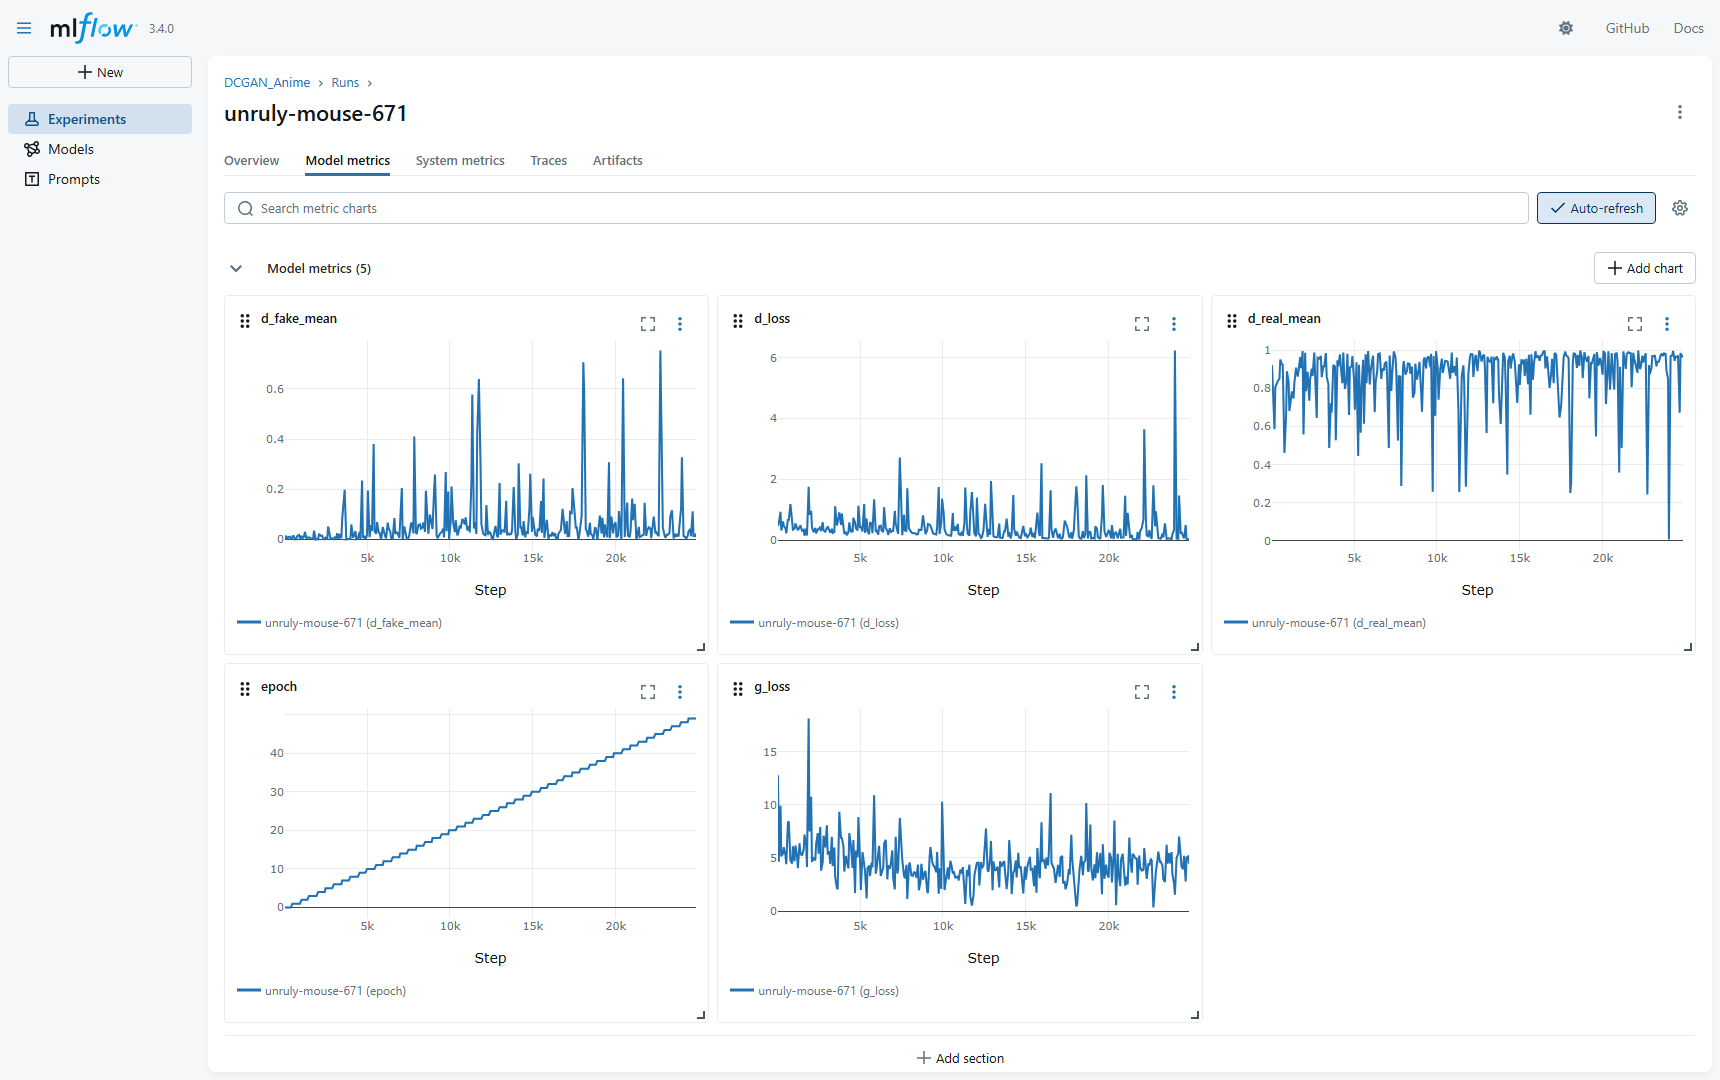

📸 Скриншот сохранен: images/main_7b9fda95f48b42a1887d2ab4a4a30560.png


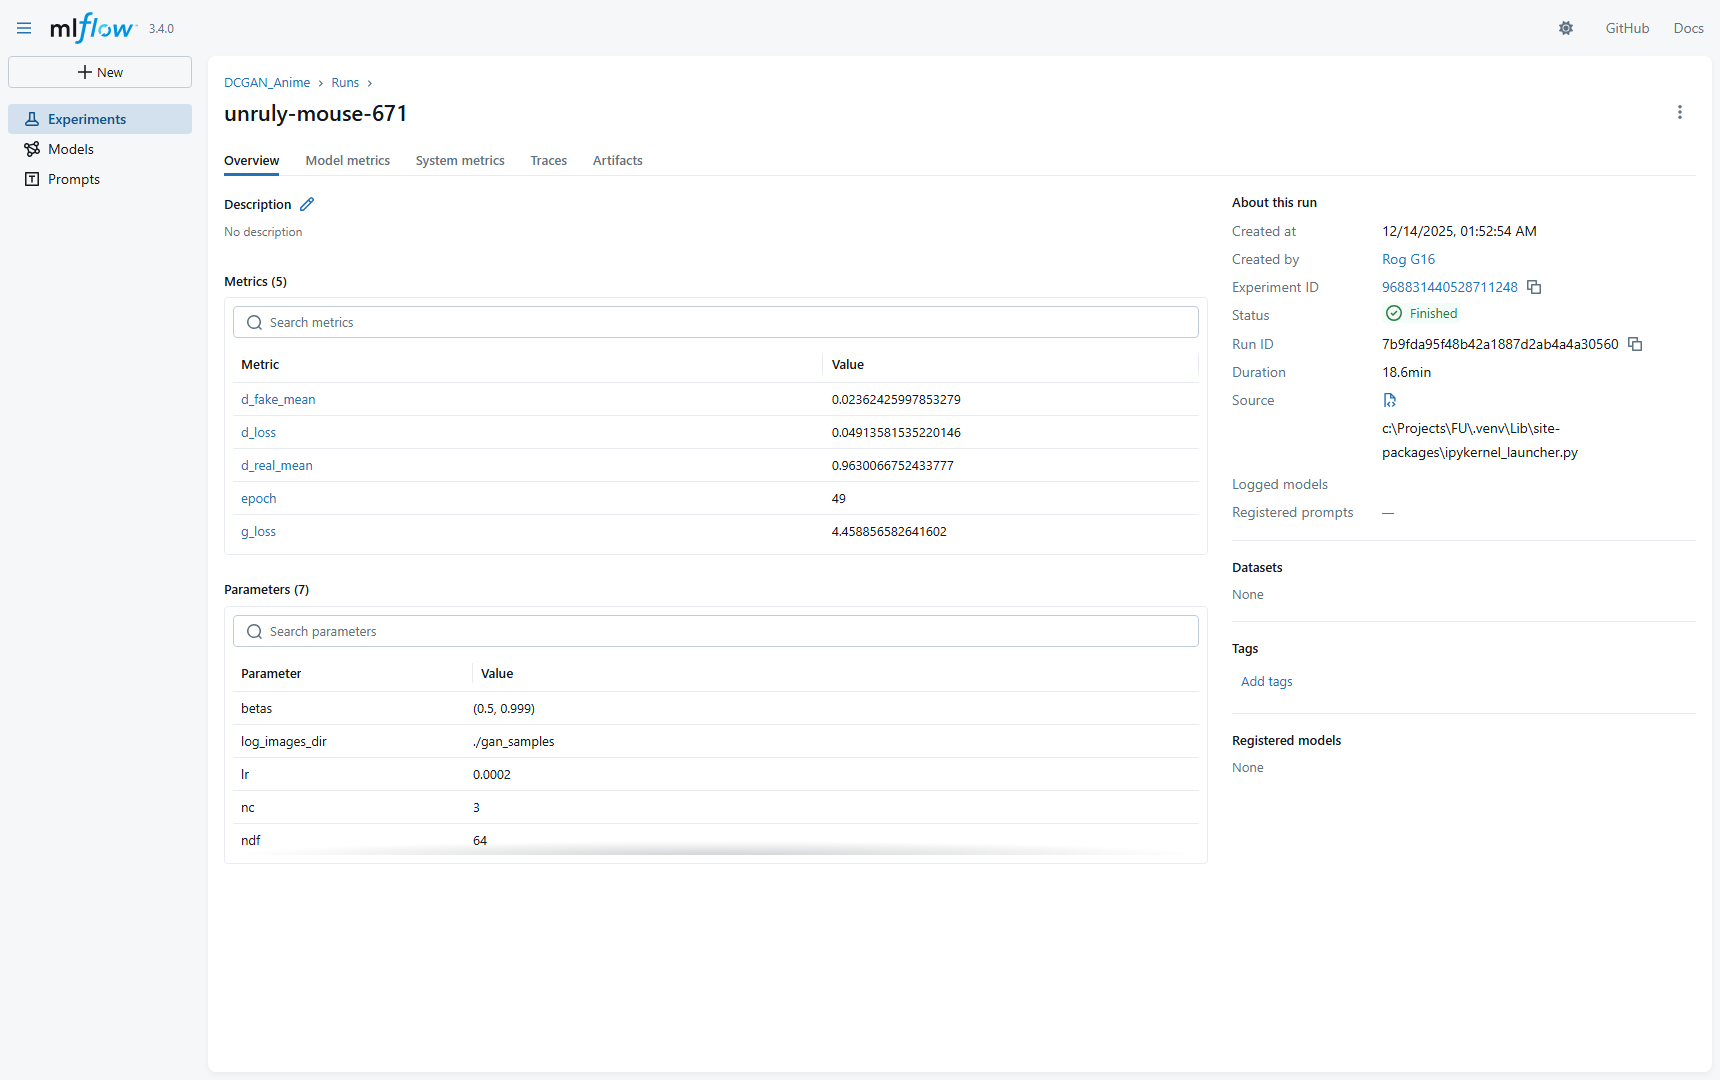

In [72]:
runs = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id])
id = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id]).dropna().index[0]
run_id = runs.iloc[id].run_id
experiment_id = runs.iloc[id].experiment_id


run_url = f"http://localhost:{port}/#/experiments/{experiment_id}/runs/{run_id}"

os.makedirs("images", exist_ok=True)
screenshot_path = f"images/run_metrics_{run_id}.png"

try:
    target_url = run_url + "/model-metrics" 
    run_screenshot_script(target_url, screenshot_path, 1720, 1080, 5)
    
    display(dispImage(filename=screenshot_path))
except Exception as e:
    print(f"Could not display screenshot: {e}")
    
screenshot_path = f"images/main_{run_id}.png"

try:
    target_url = run_url 
    run_screenshot_script(target_url, screenshot_path, 1720, 1080, 5)
    
    display(dispImage(filename=screenshot_path))
except Exception as e:
    print(f"Could not display screenshot: {e}")

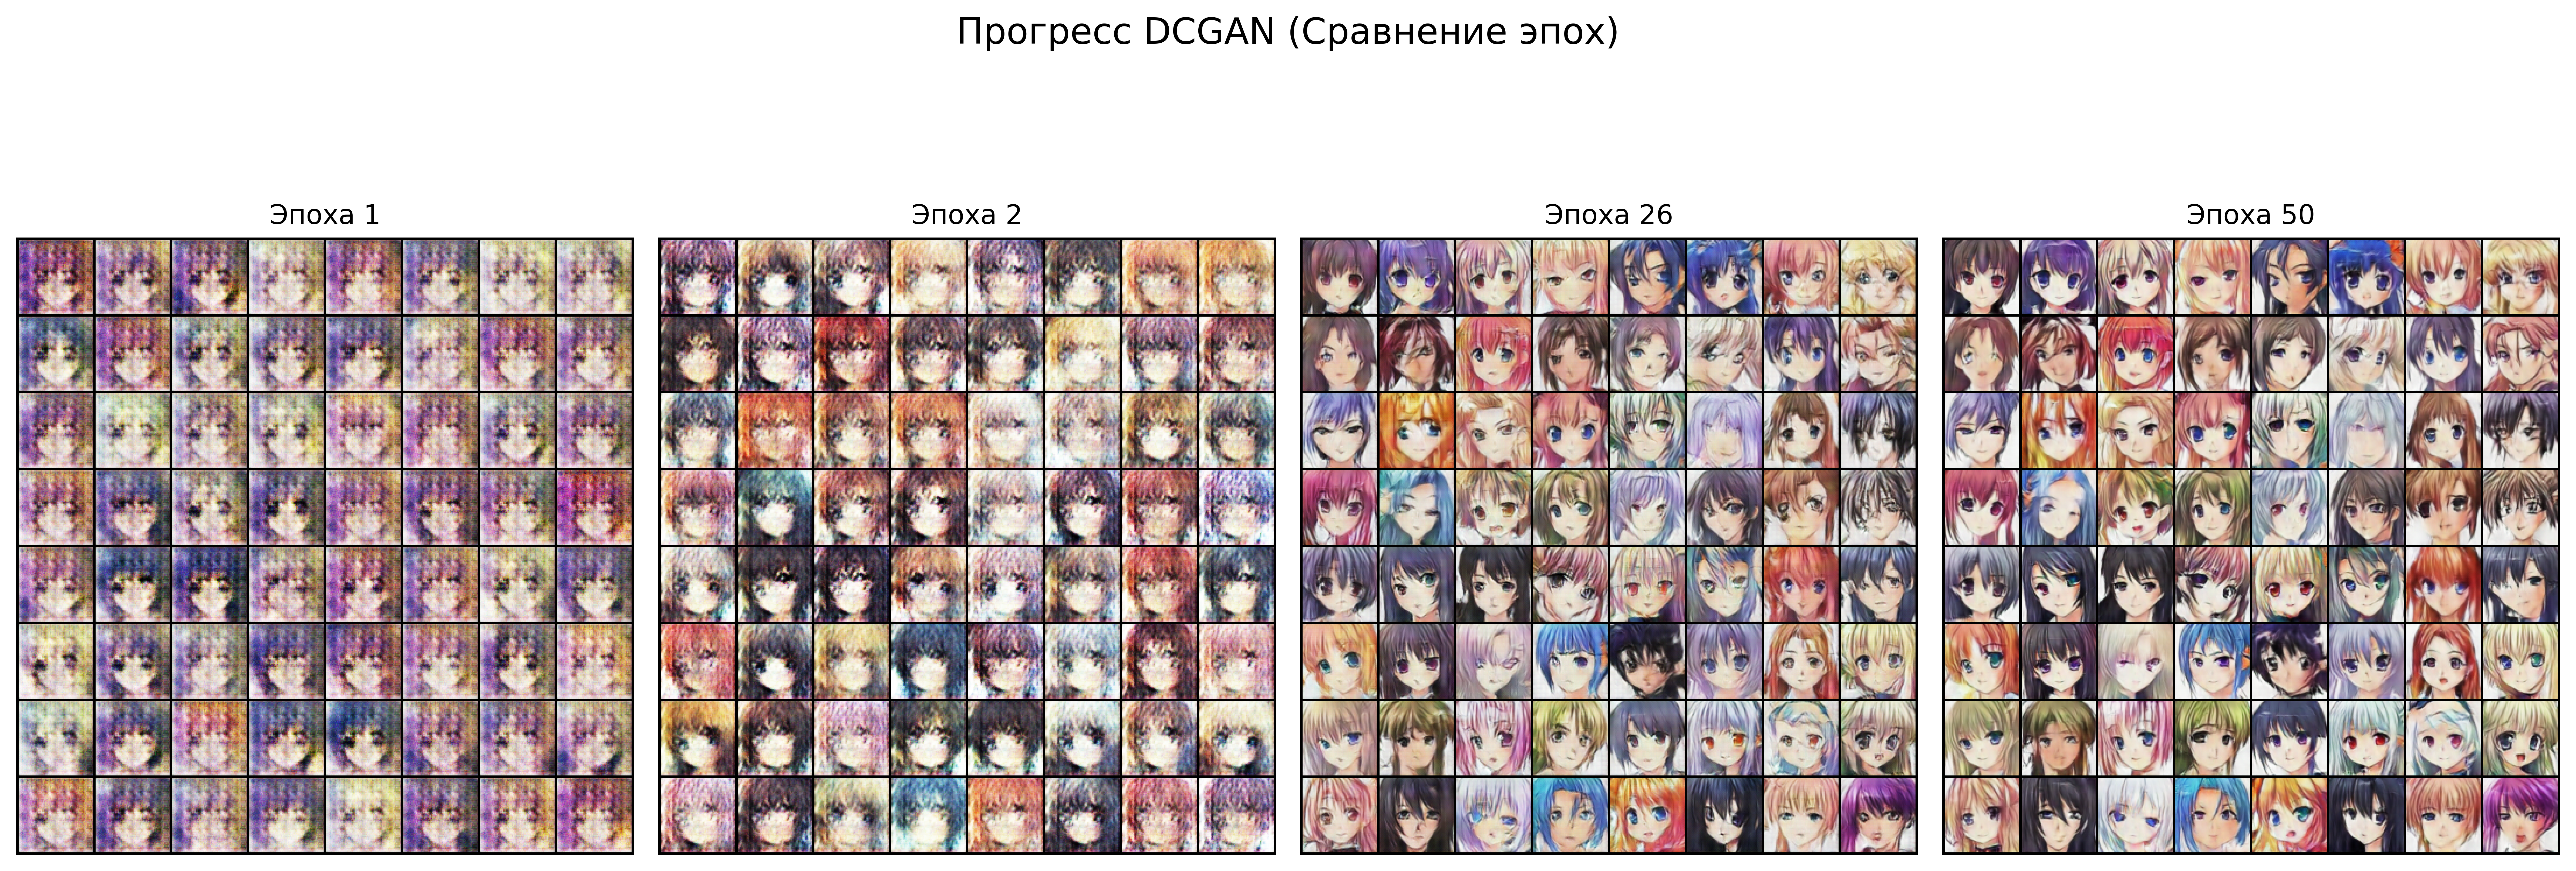

In [73]:
generated_files = sorted([f for f in os.listdir('./gan_samples') if f.endswith('.png')])

fig, axes = plt.subplots(1, min(len(generated_files), 4), figsize=(16, 6), dpi=600)
fig.suptitle("Прогресс DCGAN (Сравнение эпох)", fontsize=16)

epochs_to_show = [0, 1, MAX_EPOCHS_GAN // 2, MAX_EPOCHS_GAN - 1]
epochs_to_show = [e for e in epochs_to_show if e < len(generated_files)]

for i, epoch in enumerate(epochs_to_show):
    img = Image.open(os.path.join('./gan_samples', generated_files[epoch]))
    axes[i].imshow(img)
    axes[i].set_title(f"Эпоха {epoch+1}")
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()